In [1]:
include("sensor.jl") # To retrieve Sensor Positions
include("./doa/cbf.jl") # Conventional Beamformer
include("./doa/dbf_freeform.jl") # Differential Beamformer (coordinate-free) 
include("./doa/music.jl") # MUSIC

include("./utils/preprocess.jl")

sensors Loaded: (8,)
sensors1 Loaded: (25,)
sensors2 Loaded: (20,)
sensors_underwater loaded: (40,)


In [83]:
#=
Step 0: Open recording or generate signal
=#

# To Generate Signal:
include("./signal_generator/tone.jl")

freq = 1500;          # Frequency of Tone (in Hz)
amp = 1;            # Amplitude of Tone
duration = 30;       # Duration of Tone (in seconds)
sample_rate = 32000.0;
tone_sig, n = tone(duration, amp, freq, sample_rate);

In [84]:
include("./signal_generator/generate_sig.jl")
using DSP.Windows: hanning, rect, bartlett
az_gt = -90;        # Ground Truth Azimuth Angle (in degrees)
az_gt2 = 120;
c0 = 1500;          # Speed of Medium (in m/s)
NFFT = 2^11;
noverlap = Int(NFFT * (3 // 4));
new_sig, sample_rate = simulate_sensor_signal(tone_sig, sample_rate, sensors_underwater,
                         NFFT, noverlap, hanning, az_gt, c0);

Start Simulating Signal
Signal has size: (960000, 1)


  3.251555 seconds (804.57 k allocations: 4.379 GiB, 9.94% gc time, 1.76% compilation time)
Now Generated Signal has size: (960000, 40)


In [85]:
using Random
using DSP: db2amp, pow2db
rng = Random.seed!(1234);
noise_pow = -6; # in dB
noise = rand(rng, size(new_sig,1), size(new_sig,2));
noisy_sig = new_sig + db2amp(noise_pow) .* noise;

In [86]:
include("./doa/cbf.jl")
include("./doa/dbf_freeform.jl")

function filter_freq_per_ch(new_sig)
    new_S = []
    for sig in eachcol(new_sig)
        S_interest = choose_freq(sig, freq, sample_rate);
        push!(new_S, S_interest);
    end
    # test_sig = Matrix{}(undef, size(new_sig, 2)) 
    new_S = mapreduce(permutedims, vcat, new_S);
    return new_S
end

new_S = filter_freq_per_ch(new_sig);
noisy_S = filter_freq_per_ch(noisy_sig);

In [87]:
using Statistics
n_snapshots = 2;
Rx = cov(new_S[:,1:n_snapshots], dims=2);
Rx_n = cov(noisy_S[:, 1:n_snapshots], dims=2);
order = 3;
@time P_cbf, az_list = cbf(Rx, sensors_underwater, freq, c0)
@time P_dbf, az_list = dbf_coFree(Rx, sensors_underwater, order, freq, c0)

@time Pn_cbf, az_list = cbf(Rx_n, sensors_underwater, freq, c0)
@time Pn_dbf, az_list = dbf_coFree(Rx_n, sensors_underwater, order, freq, c0)

  0.054655 seconds (312.73 k allocations: 16.707 MiB, 96.40% compilation time)


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
  0.104413 seconds (210.16 k allocations: 11.226 MiB, 98.58% compilation time)
  0.002028 seconds (15.90 k allocations: 1.631 MiB)
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
  0.001255 seconds (13.64 k allocations: 1.110 MiB)


([949.6941466895933, 1206.3155797094473, 1484.3342630060547, 1779.7034986093126, 2088.1311146707885, 2405.1288324203815, 2726.06512321041, 3046.221044157368, 3360.8484982996606, 3665.2303278928603  …  98.75756089263899, 39.94300208141982, 21.985272236677968, 44.506457540326466, 106.65414208549123, 207.10524939295166, 344.0754782931958, 515.3343443244869, 718.2257752983086, 949.6941466895896], LinRange{Float64}(-180.0, 180.0, 361), ComplexF64[0.0 + 0.33345833620298954im 0.0 + 0.02911219603925727im … -0.043919075070704736 - 0.20519957480220197im -0.09190175280675289 - 0.029869198736457006im; -0.48543393263150914 + 0.0im 0.287880367515969 + 0.0im … 0.06488442837329897 - 0.1610303304493631im -0.07725398060918454 - 0.2378084796773874im; … ; -0.48543393263150914 + 0.0im 0.287880367515969 + 0.0im … 0.06488442837329897 + 0.1610303304493631im -0.07725398060918454 + 0.2378084796773874im; 0.0 + 0.33345833620298954im 0.0 + 0.02911219603925727im … 0.043919075070704736 - 0.20519957480220197im 0.0919

In [88]:
P_cbf_db, az_cbf_max = predict_az(P_cbf, az_list)
P_dbf_db, az_dbf_max = predict_az(P_dbf, az_list)

Pn_cbf_db, az_n_cbf_max = predict_az(Pn_cbf, az_list)
Pn_dbf_db, az_n_dbf_max = predict_az(Pn_dbf, az_list)

([-19.95239114325186, -18.91361938798677, -18.012911632021734, -17.22475221428057, -16.53065110894591, -15.916845309996269, -15.372866491006498, -14.890614615946085, -14.463739400156435, -14.087216041514935  …  -29.782525204049698, -33.71382172664186, -36.30691027902114, -33.24399847323162, -29.448451489833648, -26.56631768744935, -24.361691533689566, -22.607337887531163, -21.165618888271634, -19.952391143251877], -90.0)

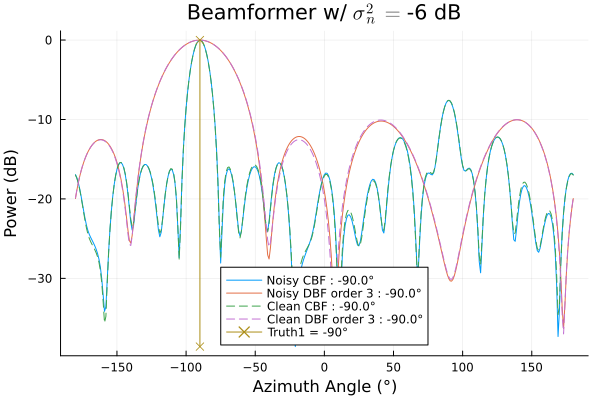

"/home/pasokon/Documents/localization/plots/noisy_beamformer.png"

In [89]:
using Plots, LaTeXStrings
ymin = minimum([P_cbf_db P_dbf_db Pn_cbf_db Pn_dbf_db])
p = plot(az_list, Pn_cbf_db, label="Noisy CBF : $(az_n_cbf_max)°", legend=:bottom)
xlabel!("Azimuth Angle (°)");
ylabel!("Power (dB)");
sig_str = L"$\sigma_{n}^{2} = $";
title_str = "Beamformer w/ " * sig_str * "$(noise_pow) dB";
title!(title_str)
plot!(az_list, Pn_dbf_db, label="Noisy DBF order $order : $(az_n_dbf_max)°")
plot!(az_list, P_cbf_db, label="Clean CBF : $(az_cbf_max)°",
    linestyle=:dash);
plot!(az_list, P_dbf_db, label="Clean DBF order $order : $(az_dbf_max)°",
    linestyle=:dash);
plot!([az_gt; az_gt], [ymin; 0], marker=:x, label="Truth1 = $(az_gt)°")

display(p)
# plot!([az_gt2; az_gt2], [ymin; 0], marker=:x, label="Truth2 = $(az_gt2)°")
savefig("./plots/noisy_beamformer.png")

In [90]:
corr_samples = 2;
max_snapshots = div(size(new_S, 2), corr_samples);
t_doa = 1:max_snapshots;
az = [];
P_cbfs = [];
P_dbfs = [];
doas_cbfs = [];
doas_dbfs = [];
@time for t in t_doa
    start = (t-1) * corr_samples + 1;
    end_t = t * corr_samples;
    Rx = cov(new_S[:, start:end_t], dims=2);

    P_cbf, az_list = cbf(Rx, sensors_underwater, freq, c0);
    P_dbf, az_list = dbf_coFree(Rx, sensors_underwater, order, freq, c0)
    __, az_cbf = predict_az(P_cbf, az_list);
    __, az_dbf = predict_az(P_dbf, az_list);

    push!(doas_cbfs, az_cbf)
    push!(doas_dbfs, az_dbf)
    push!(P_cbfs, P_cbf)
    push!(P_dbfs, P_dbf)
    if t == 1
        append!(az, az_list)
    end
end

P_cbfs = mapreduce(permutedims, vcat, P_cbfs);
P_cbfs = P_cbfs';

P_dbfs = mapreduce(permutedims, vcat, P_dbfs);
P_dbfs = P_dbfs';

weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7,

weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7,

weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7,

weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7,

weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7,

weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7,

weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7,

weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7,

weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7,

weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7,

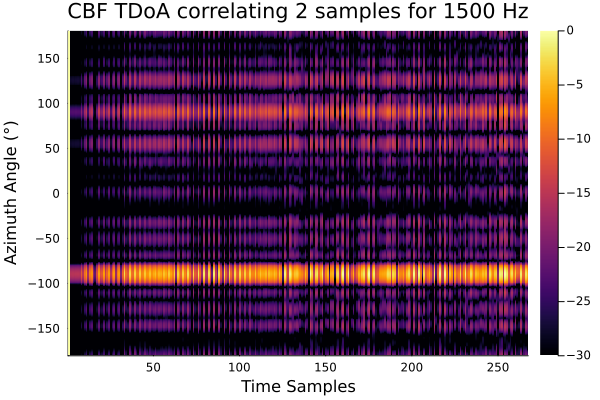

(361, 267)
  0.003034 seconds (667 allocations: 842.195 KiB)


"/home/pasokon/Documents/localization/plots/cbf_tdoa.png"

In [91]:
using DSP.Util: pow2db
P_cbfs_db = pow2db.(P_cbfs);
P_cbfs_db .-= maximum(P_cbfs_db[:,3:end-3]);
println(size(P_cbfs_db))
@time p = plot(t_doa, az_list, P_cbfs_db, st=:heatmap,
     clims=(-30.0, 0.0),
     xlabel="Time Samples",
     ylabel="Azimuth Angle (°)",
     title="CBF TDoA correlating $(corr_samples) samples for $(freq) Hz", rasterized = true)
display(p)
savefig("./plots/cbf_tdoa.png")

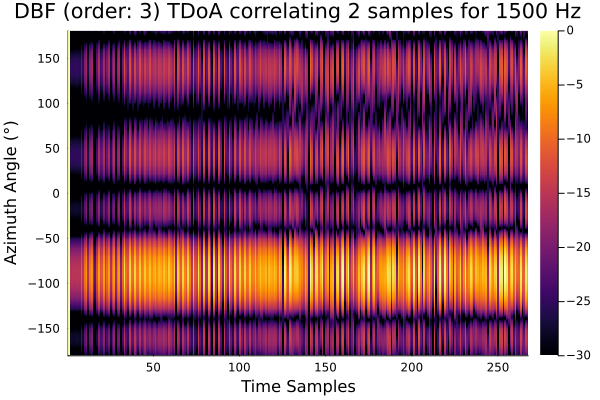

(361, 267)
  0.002977 seconds (669 allocations: 842.297 KiB)


"/home/pasokon/Documents/localization/plots/dbf_tdoa.png"

In [92]:
P_dbfs_db = pow2db.(P_dbfs);
P_dbfs_db .-= maximum(P_dbfs_db[:,3:end-3]);
println(size(P_dbfs_db))
@time p = plot(t_doa, az_list, P_dbfs_db, st=:heatmap,
     clims=(-30.0, 0.0),
     xlabel="Time Samples",
     ylabel="Azimuth Angle (°)",
     title="DBF (order: $order) TDoA correlating $(corr_samples) samples for $(freq) Hz", rasterized = true)
display(p)
savefig("./plots/dbf_tdoa.png")

In [93]:
corr_samples = 16;
max_snapshots = div(size(new_S, 2), corr_samples);
t_doa = 1:max_snapshots;
az = [];
P_cbfs = [];
P_dbfs = [];
doas_cbfs = [];
doas_dbfs = [];
@time for t in t_doa
    start = (t-1) * corr_samples + 1;
    end_t = t * corr_samples;
    Rx = cov(noisy_S[:, start:end_t], dims=2);

    P_cbf, az_list = cbf(Rx, sensors_underwater, freq, c0);
    P_dbf, az_list = dbf_coFree(Rx, sensors_underwater, order, freq, c0)
    __, az_cbf = predict_az(P_cbf, az_list);
    __, az_dbf = predict_az(P_dbf, az_list);

    push!(doas_cbfs, az_cbf)
    push!(doas_dbfs, az_dbf)
    push!(P_cbfs, P_cbf)
    push!(P_dbfs, P_dbf)
    if t == 1
        append!(az, az_list)
    end
end

P_cbfs = mapreduce(permutedims, vcat, P_cbfs);
P_cbfs = P_cbfs';

P_dbfs = mapreduce(permutedims, vcat, P_dbfs);
P_dbfs = P_dbfs';

weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7,

weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
  0.109822 seconds (976.46 k allocations: 92.212 MiB)


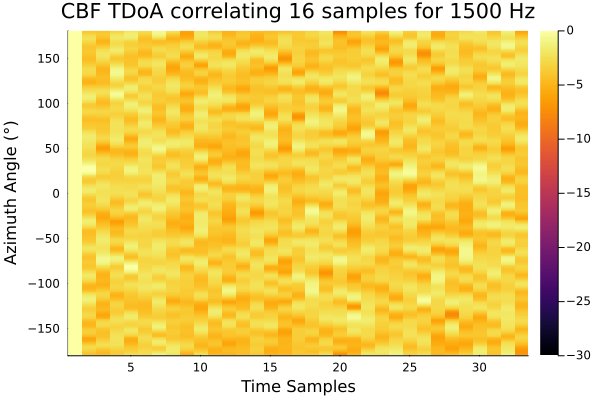

(361, 33)
  0.001026 seconds (667 allocations: 180.336 KiB)


"/home/pasokon/Documents/localization/plots/cbf_noisy_tdoa.png"

In [94]:
using DSP.Util: pow2db
P_cbfs_db = pow2db.(P_cbfs);
P_cbfs_db .-= maximum(P_cbfs_db[:,3:end-3]);
println(size(P_cbfs_db))
@time p = plot(t_doa, az_list, P_cbfs_db, st=:heatmap,
     clims=(-30.0, 0.0),
     xlabel="Time Samples",
     ylabel="Azimuth Angle (°)",
     title="CBF TDoA correlating $(corr_samples) samples for $(freq) Hz", rasterized = true)
display(p)
savefig("./plots/cbf_noisy_tdoa.png")

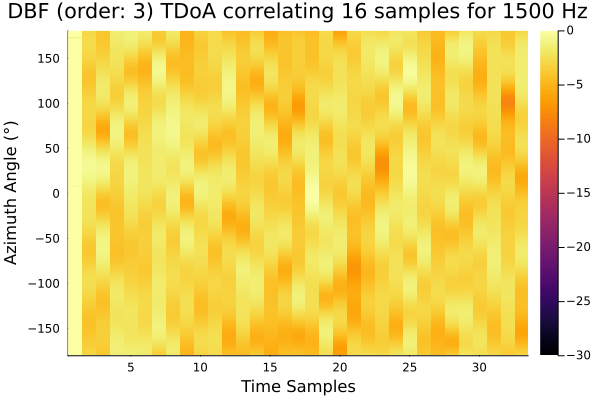

(361, 33)
  0.000993 seconds (669 allocations: 180.438 KiB)


"/home/pasokon/Documents/localization/plots/dbf_noisy_tdoa.png"

In [95]:
P_dbfs_db = pow2db.(P_dbfs);
P_dbfs_db .-= maximum(P_dbfs_db[:,3:end-3]);
println(size(P_dbfs_db))
@time p = plot(t_doa, az_list, P_dbfs_db, st=:heatmap,
     clims=(-30.0, 0.0),
     xlabel="Time Samples",
     ylabel="Azimuth Angle (°)",
     title="DBF (order: $order) TDoA correlating $(corr_samples) samples for $(freq) Hz", rasterized = true)
display(p)
savefig("./plots/dbf_noisy_tdoa.png")